# Data Preprocessing

In [ ]:
!pip install git+https://github.com/elastic/ember.git

  Cloning https://github.com/elastic/ember.git to /tmp/pip-req-build-rgafisdm
  Running command git clone -q https://github.com/elastic/ember.git /tmp/pip-req-build-rgafisdm
     |████████████████████████████████| 3.9 MB 4.0 MB/s 
  Created wheel for ember: filename=ember-0.1.0-py3-none-any.whl size=12685 sha256=f9a88e8a0f38e77f077b24b2b8424c28e3a0d08e81c86e42a5b60018ad866c73
  Stored in directory: /tmp/pip-ephem-wheel-cache-36n3dxme/wheels/0d/0c/d5/8bf798260ec4c5ab76e1cd3aef7489cd84fe1a4284ef80108b
Successfully built ember


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import ember
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, Activation
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [ ]:
def init_vectorized_features(dataset_dir: str):
    """
    Required for the generation of '.dat' data files
    :param dataset_dir: directory to the base location of the dataset
    :return:
    """
    try:
        assert(os.path.exists(dataset_dir))

        ember.create_vectorized_features(dataset_dir, 1, scale = 0.2)
    except AssertionError:
        raise Exception("[ASSERTION ERROR] The path to base directory of dataset provided does not exist")


def dat_to_train_test(dat_dir: str):
    """
    Loading training & testing data from respective generated '.dat' files
    :param dat_dir: directory to the base location where generated '.dat' files are found
    :return:
    """
    try:
        assert('X_train.dat' in os.listdir(dat_dir))
        assert('y_train.dat' in os.listdir(dat_dir))
        assert ('X_test.dat' in os.listdir(dat_dir))
        assert ('y_test.dat' in os.listdir(dat_dir))

        x_train, y_train = ember.read_vectorized_features(dat_dir, subset="train", feature_version= 1)
        x_test, y_test = ember.read_vectorized_features(dat_dir, subset="test", feature_version= 1)

        return x_train, y_train, x_test, y_test
    except AssertionError:
        raise Exception("[ASSERTION ERROR] Ensure that the required '.dat' files are found within the specified directory")


def __dataset_generator(data: np.memmap, labels: np.memmap):
    """
    Helper function for conversion from numpy.memmap to tf.data.Dataset
    Create callable generator for tf.data.Dataset.from_generator()
    :param data: numpy.memmap of training data
    :param labels: numpy.memmap of labels corresponding to the training data
    :return:
    """
    # requires nothing to be passed to generator to avoid "TypeError: 'generator' must be callable." error
    def generator():
        for instance, label in zip(data, labels):
            yield instance, label
    return generator


# Neural Network Based Malware Detection

In [ ]:
class MalwareDetectionNN:
    def __init__(self, num_attributes, num_classes):
        """
        Constructor for Malware Detection Neural Network model
        """
        weight_decay = 5e-4
        regularizer = regularizers.l2(weight_decay)

        self.__history = None
        self.__model = Sequential()
        self.__model.add(Conv1D(128, 64, strides=64, activation='relu', kernel_regularizer=regularizer, input_shape=(dim, 1)))
        self.__model.add(BatchNormalization())
        self.__model.add(Conv1D(128, 3, strides=2, kernel_regularizer=regularizer,activation='relu'))
        self.__model.add(BatchNormalization())
        self.__model.add(Flatten())
        self.__model.add(Dense(256, kernel_regularizer=regularizer, activation='relu'))
        self.__model.add(BatchNormalization())
        self.__model.add(Dense(32, kernel_regularizer=regularizer, activation='relu'))
        self.__model.add(BatchNormalization())
        self.__model.add(Dense(num_classes, kernel_regularizer=regularizer, activation='softmax'))


    def summary(self):
        """
        Output overview of model structure and parameters
        :return:
        """
        self.__model.summary()


    def __compile(self, learning_rate: float = 0.001, optimizer: tf.keras.optimizers = tf.keras.optimizers.Adam,
                  loss_function: tf.keras.losses = tf.keras.losses.BinaryCrossentropy):
        """
        Private method for compiling the model to be used within the training and testing methods of the
        MalwareDetection model instances
        :param learning_rate: Learning rate specified for the initialization of the optimizer
        :param optimizer: Type of optimizer to be used to best suite the model training
        :param loss_function: Type of loss function to best represent the desired output prediction type
        :return:
        """
        optimizer = Adam(learning_rate)
        self.__model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    def train(self, x_train, y_train, checkpoint_path, validation = None, epochs: int = 25, batch_size: int = 1000,
              learning_rate: float = 0.001, optimizer: tf.keras.optimizers = tf.keras.optimizers.Adam,
              loss_function: tf.keras.losses = tf.keras.losses.BinaryCrossentropy):
        """
        Training function for Malware Detection Neural Network model
        :param train_dataset: Dataset used to train the malware detection model
        :param validation_dataset: Dataset for validation of the malware prediction model accuracy during training
        :param epochs: number of epochs for training the detection model
        :param learning_rate: Learning rate specified for the initialization of the optimizer
        :param optimizer: Type of optimizer to be used to best suite the model training
        :param loss_function: Type of loss function to best represent the desired output prediction type
        :return:
        """
        callbacks = [tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True), ]

        self.__compile(learning_rate, optimizer, loss_function)
        if validation is None:
            self.__history = self.__model.fit(x_train, y_train,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              callbacks=callbacks)
        else:
            self.__history = self.__model.fit(x_train, y_train,
                                              validation_data=validation,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              callbacks=callbacks)

        self.__plot_training_performance()


    def __plot_training_performance(self):
        """
        Private function to be run after training in order to visualize the accuracy behaviour of the training on the
        train and validation subsets of training dataset
        :return:
        """
        plt.plot(self.__history.history['accuracy'], label='training accuracy')
        # plt.plot(self.__history.history['val_accuracy'], label='validation accuracy')
        plt.xlabel("Epoch")
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

# Utils

In [ ]:
def save(path, val):
  with open(path, 'wb') as file:
      
    # A new file will be created
    pickle.dump(val, file, protocol=4)

def load(path):
  with open(path, 'rb') as file:
      
    # Call load method to deserialze
    return pickle.load(file)

# PE files

The Portable Executable format is a file format for executables, object code, DLLs and others used in Windows operating systems.

# Ember Dataset

The EMBER dataset is a collection of features from PE files that serve as a benchmark dataset for researchers. The EMBER2017 dataset contained features from 1.1 million PE files scanned in or before 2017. <br>

It consists of a collection of JSON lines
files, where each line contains a single JSON object. Each
object includes the following labels:

0 -> Benign <br>
1 -> Malignant <br>
-1 -> Unlabelled

# Steps


1. Convert features into dataset
2. Split to train test
3. Vectorize the labels
4. Validation Split
5. Normalize it
6. Expand the dimensions
7. Build the model
8. Train the model
9. Test the model
10. Save the model





## The model gives an accuracy of **97.6%** on test data

# Run 

In [ ]:
FILTERED_DATASET_SIZES = 600000

BATCH_SIZE = 32
EPOCHS = 5
num_classes = 2
split = 0.85

DATA_DIR = '/content/drive/MyDrive/ember_dataset/ember'
PCA_PATH = '/content/drive/MyDrive/pca_dump.pkl'
NOR_PATH = '/content/drive/MyDrive/nor_dump.pkl'
SCALER_PATH = '/content/drive/MyDrive/scaler_dump.pkl'
CHK_PATH = '/content/drive/MyDrive/Checkpoints/Save_at_{epoch}.h5'

# Feature extraction

Raw features are extracted to JSON format and included in the publicly available dataset. Vectorized features can be produced from these raw features and saved in binary format from which they can be converted to CSV, dataframe, or any other format

In [ ]:
init_vectorized_features(DATA_DIR)

In [ ]:
X_train, Y_train, x_test, y_test = dat_to_train_test(DATA_DIR)

Remove the unlabelled items

In [ ]:
X_train = X_train[Y_train != -1]
Y_train = Y_train[Y_train != -1]

Shuffle the dataset

In [ ]:
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
Y_train = Y_train[indices]

Split into train and valididation sets

In [ ]:
idx = int(split * X_train.shape[0])
X_val, Y_val = X_train[idx:], Y_train[idx:]
X_train, Y_train = X_train[:idx], Y_train[:idx]

Converts integer labels to binary class matrix: <br>
[0 1] -> Malignant<br>
[1 0] -> Benign

In [ ]:
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_val = to_categorical(Y_val, num_classes=num_classes)

Reduce the dataset size

In [ ]:
idx = int((0.25) * X_val.shape[0])
X_val, Y_val = X_val[:idx], Y_val[:idx]

Normalize the dataset

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
save(SCALER_PATH, scaler) 

In [ ]:
save(NOR_PATH, [X_train, Y_train, X_val, Y_val])

Add an extra dimension as the model expects a 3D input.

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1) 

Create the model

In [ ]:
# Create the instance of the MalwareDetection model
dim = X_train.shape[1]
model = MalwareDetectionNN(len(X_train[1]), num_classes)
model.summary()

Train the model

Epoch 1/5
3985/3985 [==============================] - 556s 139ms/step - loss: 0.2688 - accuracy: 0.9575 - val_loss: 0.1908 - val_accuracy: 0.9733

Epoch 00001: val_accuracy improved from -inf to 0.97329, saving model to /content/drive/MyDrive/Checkpoints/Save_at_1.h5
Epoch 2/5
3985/3985 [==============================] - 593s 149ms/step - loss: 0.1864 - accuracy: 0.9684 - val_loss: 0.1950 - val_accuracy: 0.9724

Epoch 00002: val_accuracy did not improve from 0.97329
Epoch 3/5
3985/3985 [==============================] - 597s 150ms/step - loss: 0.1727 - accuracy: 0.9716 - val_loss: 0.1734 - val_accuracy: 0.9755

Epoch 00003: val_accuracy improved from 0.97329 to 0.97547, saving model to /content/drive/MyDrive/Checkpoints/Save_at_3.h5
Epoch 4/5
3985/3985 [==============================] - 564s 142ms/step - loss: 0.1597 - accuracy: 0.9741 - val_loss: 0.1476 - val_accuracy: 0.9786

Epoch 00004: val_accuracy improved from 0.97547 to 0.97858, saving model to /content/drive/MyDrive/Checkpoin

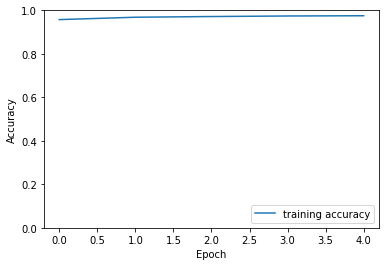

In [ ]:
model.train(X_train, Y_train, CHK_PATH,
                (X_val, Y_val),
                batch_size= BATCH_SIZE,
                epochs=EPOCHS,
                optimizer=tf.keras.optimizers.Adam,
                learning_rate=0.001)

Run the model on the test dataset

In [ ]:
X_test = x_test[y_test != -1]
y_test = y_test[y_test != -1]

In [ ]:
y_test = to_categorical(y_test, num_classes=num_classes)
X_test = scaler.transform(X_test)

In [ ]:
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Checkpoints/Save_at_4.h5")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print(test_loss)
print(test_acc)

6250/6250 [==============================] - 35s 6ms/step - loss: 0.1675 - accuracy: 0.9765
0.16750022768974304
0.976485013961792


In [ ]:
x_train.shape

(900000, 2351)